In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, grangercausalitytests, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as sm

from datetime import datetime, timedelta
import os

from pykalman import KalmanFilter
from math import sqrt

# check how much of historical orderbook can be gotten
# entering into position slippage can be simulated here

In [2]:
def KalmanFilterAverage(x):
  # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],
    observation_matrices = [1],
    initial_state_mean = 0,
    initial_state_covariance = 1,
    observation_covariance=1,
    transition_covariance=.01)
  # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means
# Kalman filter regression
def KalmanFilterRegression(x,y):
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
    initial_state_mean=[0,0],
    initial_state_covariance=np.ones((2, 2)),
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat,
    observation_covariance=2,
    transition_covariance=trans_cov)
    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)
    return state_means
def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]
    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]
    spread_lag2 = sm.add_constant(spread_lag)
    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))
    if halflife <= 1:
        halflife = 1
    return halflife

In [ ]:
# for now lets skip this for live iterating

# def run_adfuller_test(spread):
#     '''
#     run cointegration test if there are more than 100 observations
#     H0: that there is a unit root -> no stationarity
#     H1: there is no unit root -> stationary
#     pval > threshold value: cannot reject H0'''
#     if len(spread) >= 100:
#         '''settings for regression testing:
#         https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
#         here we assume no time trend in time series and no drift for simplicity!'''
#         return float(sm.tsa.adfuller(x=spread)[1])  # ,regression='ctt'
#     else:
#         return np.nan
      
# def run_johansen_test(data):
#     result = coint_johansen(data, det_order=0, k_ar_diff=1)
#     """r = 0 means no cointegration, r<=1 means up to one cointegration relationship etc
#     We have m hypothesised numbers of cointegrated equations: here at most 0, at most 1 
#     cvt - Critical values (90%, 95%, 99%) of trace statistic
#     lr1 - Trace statistic
#     Trace test:
#     H0: 0 cointegration equations
#     H1: coint. eq. exist > 0 
#     explanation https://www.youtube.com/watch?v=TB4m9M1sIJ0
#     """
#     stat_r0 = result.lr1[0]
#     crits_r0 = result.cvt[0]
#     # eig_stat_r0 = result.lr2[0]
#     # eig_crits_r0 = result.cvm[0]
#     stat_res = trace_results(stat_r0, crits_r0)  # there are 0 coint. equations. pass if rejected
#     # eig_res = trace_results(eig_stat_r0, eig_crits_r0)  # there are 0 coint. equations. pass if rejected
#     return stat_res

# def run_engel_granger(ts1, ts2):
#     '''H0: there is no cointegration
#     H1: there is cointegration relationship
#     pval < threshold value: reject H0
#     time series are assumed to be integrated of order 1!!!'''
#     return sm.tsa.coint(ts1, ts2, autolag='bic')[1]

In [83]:
class IterativeBacktester:
  def __init__(
    self,
    pair,
    raw_data_dir,
    ticker_interval,
    save_dir="./processed_data",
    perc_opt_range=None,
    tc=0.0006
    ):
    
    # global settings
    self.pair = pair
    self.ticker1 = pair[0]
    self.ticker2 = pair[1]
    self.raw_data_dir = raw_data_dir
    self.ticker_interval = ticker_interval
    self.tc = tc
    
    # current backtest settings
    self.tp = None
    self.sl = None
    self.window = None
    self.z_short_perc = None
    self.z_long_perc = None
    
    # experimental feature to be implemented
    # so that every step we check certain range of percentiles
    # and take one with the highest profit results
    self.perc_opt_range = perc_opt_range
    
    #data
    self.data = None
    self.result = None
    self.opt_overview = None
    
    self._get_data()
    
  def __repr__(self):
      return "Pairs trading backtester"
        
  def _get_data(self):
    entries = []
    for instrument in self.pair:
      entries.append("%s_%s.csv" % (instrument, self.ticker_interval))
    # removing duplicates
    entries = list(set(entries))
      
    df_closings = pd.DataFrame()
    for entry in entries:
      instrument = "_".join(entry.split("_")[0:-1])
      df = pd.read_csv('%s/%s' % (self.raw_data_dir, entry), index_col="Date", parse_dates=["Date"])
      df = df[["Close"]].copy()
      df.columns = [instrument]
      df["%s_returns_log" % instrument] = np.log(df[instrument]/df[instrument].shift(1))
      df_closings = pd.concat([df_closings, df], axis=1)
      
      
    df_closings.dropna(inplace=True)
    df_closings = df_closings.T.drop_duplicates().T
    self.data = df_closings
    self.tp_year = (self.data.shape[0] / ((self.data.index[-1] - self.data.index[0]).days / 365.25))
    
      
  def backtest_pair(
    self,
    window=48,
    z_short_perc=95,
    z_long_perc=5,
    tp=0.01,
    sl=-0.01,
    avg_kalman=False,
    rolling_z_window=None,
    ):
    
    self.tp = tp
    self.sl = sl
    self.window = window
    self.z_short_perc = z_short_perc
    self.z_long_perc = z_long_perc
    
    inst1 = self.pair[0]
    inst2 = self.pair[1]
    data = self.data.copy()
    
    data["signals"] = 0
    data["%s_position" % inst1] = 0
    data["%s_position" % inst2] = 0
    data["spread"] = 0
    data["zscore"] = 0
    data["z_long"] = 0
    data["z_short"] = 0
    data["gross_returns"] = 0
    data["net_returns"] = 0
    
    signal = 0
    old_signal = 0
    current_return = 0
    position1 = 0
    position2 = 0
    
    # moving through the sample
    for t in range(window, len(data)-1):
      # # because of sampling index is off when sample[t]
      sample = data.iloc[t-window:t+2].copy()

      old_signal = signal
      old_position1 = position1
      old_position2 = position2
      gross = 0
      net = 0
      
      spread, hedge_ratio = get_Kalman_spread(sample[inst1], sample[inst2], avg_kalman=avg_kalman)
      current_z_score, z_score_series = get_current_zscore(spread, rolling_window=rolling_z_window)
      
      z_percentiles = np.percentile(z_score_series, [z_long_perc, z_short_perc])
      z_long = z_percentiles[0]
      z_short = z_percentiles[1]
      
      if old_signal == 0:
        if current_z_score < z_long: 
          signal = 1
        if current_z_score > z_short: 
          signal = -1
      if old_signal != 0:
        if current_return >= tp:
          signal = 0
        # elif current_return <= sl:
        elif net <= sl and current_return <= sl:
          signal = 0
        
      position1 = -signal
      position2 = signal

      # check out what type of index is within the sample & if usage of "window+1" is legit
      gross = position1*sample["%s_returns_log" % inst1][window+1] + position2*sample["%s_returns_log" % inst2][window+1]
      net = gross - self.tc*(abs(position1 - old_position1) + abs(position2 - old_position2))
      if signal == old_signal:
        current_return = (1+current_return)*(1+net)-1
        # current_return = current_return + gross # logs should be additive
      else:
        # should check if we have curr_pos_return
        current_return = net

      data.loc[[data.index[t]], ["%s_position" % inst1]] = position1
      data.loc[[data.index[t]], ["%s_position" % inst2]] = position2
      data.loc[[data.index[t]], ["signals"]] = signal
      data.loc[[data.index[t]], ["gross_returns"] ] = gross
      data.loc[[data.index[t]], ["net_returns"]] = net
      data.loc[[data.index[t]], ["zscore"]] = current_z_score
      data.loc[[data.index[t]], ["z_long"]] = z_long
      data.loc[[data.index[t]], ["z_short"]] = z_short
      data.loc[[data.index[t]], ["spread"]] = spread.iloc[-1]
      

      # interface: reporting daily positions and realised returns
      print(100 * "=")
      if signal == 0:
          print('NO TRADING')
      elif  signal == 1:
          print('LONG: '+inst2+' SHORT: '+inst1)
      else:
          print('LONG: '+inst1+' SHORT: '+inst2)
      print("CUM RET: ", str(round(np.prod(1+data["net_returns"])*100-100, 2)) + '%', 'NET: ', current_return, "POS: ", signal)
      print(str(data.index[t]), t, "/", len(data)-1)
      
    # add cum ret gross & net to the saved dataset
    data["gross_cum"] = data["gross_returns"].cumsum().apply(np.exp)
    data["net_cum"] = data["net_returns"].cumsum().apply(np.exp)
    self.result = data

    # plotting equity curves
    self.result["gross_cum"].plot(figsize=(12, 8))
    self.result["net_cum"].plot()
    plt.show()
      
  def get_backtest_report(self):
    ''' Calculates and prints various Performance Metrics.
    '''
    
    data = self.results.copy()
    strategy_multiple = round(self.calculate_multiple(data.strategy), 6)
    bh_multiple =       round(self.calculate_multiple(data.returns), 6)
    outperf =           round(strategy_multiple - bh_multiple, 6)
    cagr =              round(self.calculate_cagr(data.strategy), 6)
    ann_mean =          round(self.calculate_annualized_mean(data.strategy), 6)
    ann_std =           round(self.calculate_annualized_std(data.strategy), 6)
    sharpe =            round(self.calculate_sharpe(data.strategy), 6)
    
    print(100 * "=")
    print("TRIPLE SMA STRATEGY | INSTRUMENT = {} | SMAs = {}".format(self.symbol, [self.SMA_S, self.SMA_M, self.SMA_L]))
    print(100 * "-")
    print("PERFORMANCE MEASURES:")
    print("\n")
    print("Multiple (Strategy):         {}".format(strategy_multiple))
    print("Multiple (Buy-and-Hold):     {}".format(bh_multiple))
    print(38 * "-")
    print("Out-/Underperformance:       {}".format(outperf))
    print("\n")
    print("CAGR:                        {}".format(cagr))
    print("Annualized Mean:             {}".format(ann_mean))
    print("Annualized Std:              {}".format(ann_std))
    print("Sharpe Ratio:                {}".format(sharpe))
    
    print(100 * "=")
  
  def get_backtest_charts(self, save=False):
    pass
    
      
# HELPERS

def KalmanFilterAverage(x):
  # Construct a Kalman filter
  kf = KalmanFilter(transition_matrices = [1],
  observation_matrices = [1],
  initial_state_mean = 0,
  initial_state_covariance = 1,
  observation_covariance=1,
  transition_covariance=.01)
  # Use the observed values of the price to get a rolling mean
  state_means, _ = kf.filter(x.values)
  state_means = pd.Series(state_means.flatten(), index=x.index)
  return state_means

# Kalman filter regression
def KalmanFilterRegression(x,y):
  delta = 1e-3
  trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
  obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)
  kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
  initial_state_mean=[0,0],
  initial_state_covariance=np.ones((2, 2)),
  transition_matrices=np.eye(2),
  observation_matrices=obs_mat,
  observation_covariance=2,
  transition_covariance=trans_cov)
  # Use the observations y to get running estimates and errors for the state parameters
  state_means, state_covs = kf.filter(y.values)
  return state_means

def half_life(spread):
  spread_lag = spread.shift(1)
  spread_lag.iloc[0] = spread_lag.iloc[1]
  spread_ret = spread - spread_lag
  spread_ret.iloc[0] = spread_ret.iloc[1]
  spread_lag2 = sm.add_constant(spread_lag)
  model = sm.OLS(spread_ret,spread_lag2)
  res = model.fit()
  halflife = int(round(-np.log(2) / res.params[1],0))
  if halflife <= 1:
      halflife = 1
  return halflife
  
def calculate_max_dd(self, cumret):
  # ======================================================
  # calculation of maximum drawdown and maximum drawdown duration based on
  # cumulative COMPOUNDED returns. cumret must be a compounded cumulative return.
  # i is the index of the day with maxDD.
  # ======================================================
  highwatermark=np.zeros(cumret.shape)
  drawdown=np.zeros(cumret.shape)
  drawdown_duration=np.zeros(cumret.shape)
  for t in np.arange(1, cumret.shape[0]):
      highwatermark[t]=np.maximum(highwatermark[t-1],
      cumret[t])
      drawdown[t]=(1+cumret[t])/(1+highwatermark[t])-1
      if drawdown[t]==0:
          drawdown_duration[t]=0
      else:
          drawdown_duration[t]=drawdown_duration[t-1]+1
  max_dd, i = np.min(drawdown), np.argmin(drawdown) 
  # drawdown < 0 always
  max_ddd=np.max(drawdown_duration)
  return max_dd, max_ddd, i

def get_Kalman_spread(series1, series2, avg_kalman=False):
  if avg_kalman is True:
    state_means = KalmanFilterRegression(KalmanFilterAverage(series1), KalmanFilterAverage(series2))
  else:
    state_means = KalmanFilterRegression(series1, series2)
        
  hedge_ratio = - state_means[:,0]
  spread = series1 + (series2 * hedge_ratio)
  
  return spread, hedge_ratio

def get_current_zscore(series, rolling_window=None):
  if rolling_window is not None:
    # this windows definitely could be optimized or sth
    spread_mean = series.rolling(center=False, window=rolling_window).mean()
    spread_std = series.rolling(center=False, window=rolling_window).std()
    z_score_series = (series-spread_mean)/spread_std
  else:  
    z_score_series = (series-series.mean())/series.std()
    
  return z_score_series.iloc[-1], z_score_series

In [84]:
import warnings
warnings.filterwarnings('ignore')

backtester = IterativeBacktester(pair=["AUDIOUSDT_FUTURES", "FTMUSDT_FUTURES"], ticker_interval="15m", raw_data_dir="../raw_data/Binance_Historical_15m_FUTURES_20_days_2022-07-14T12:00:43", tc=0.0006)


NO TRADING
NET:  0.0 POS:  0 CUM RET:  0%
DATE: 2022-06-29 17:30:00 500 / 1918


NO TRADING
NET:  0.0 POS:  0 CUM RET:  0%
DATE: 2022-06-29 17:45:00 501 / 1918


NO TRADING
NET:  0.0 POS:  0 CUM RET:  0%
DATE: 2022-06-29 18:00:00 502 / 1918


NO TRADING
NET:  0.0 POS:  0 CUM RET:  0%
DATE: 2022-06-29 18:15:00 503 / 1918


NO TRADING
NET:  0.0 POS:  0 CUM RET:  0%
DATE: 2022-06-29 18:30:00 504 / 1918


NO TRADING
NET:  0.0 POS:  0 CUM RET:  0%
DATE: 2022-06-29 18:45:00 505 / 1918


NO TRADING
NET:  0.0 POS:  0 CUM RET:  0%
DATE: 2022-06-29 19:00:00 506 / 1918


NO TRADING
NET:  0.0 POS:  0 CUM RET:  0%
DATE: 2022-06-29 19:15:00 507 / 1918


NO TRADING
NET:  0.0 POS:  0 CUM RET:  0%
DATE: 2022-06-29 19:30:00 508 / 1918


NO TRADING
NET:  0.0 POS:  0 CUM RET:  0%
DATE: 2022-06-29 19:45:00 509 / 1918


NO TRADING
NET:  0.0 POS:  0 CUM RET:  0%
DATE: 2022-06-29 20:00:00 510 / 1918


NO TRADING
NET:  0.0 POS:  0 CUM RET:  0%
DATE: 2022-06-29 20:15:00 511 / 1918


NO TRADING
NET:  0.0 POS:  

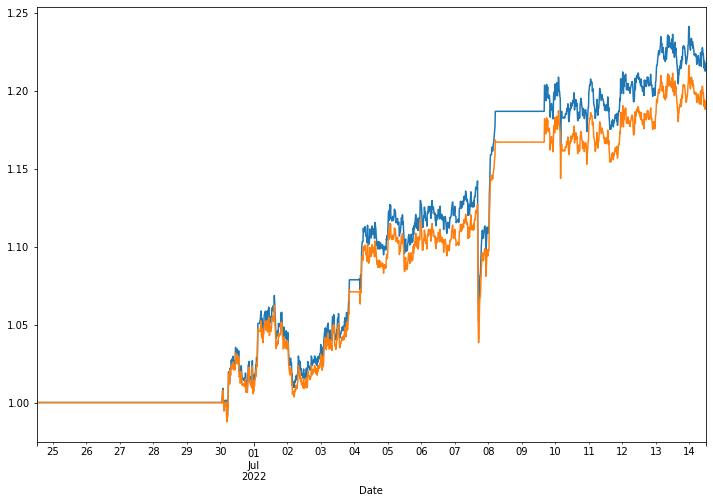

In [85]:
backtester.backtest_pair(z_long_perc=4, z_short_perc=96, window=500, tp=0.02, sl=-0.005)

<AxesSubplot:xlabel='Date'>

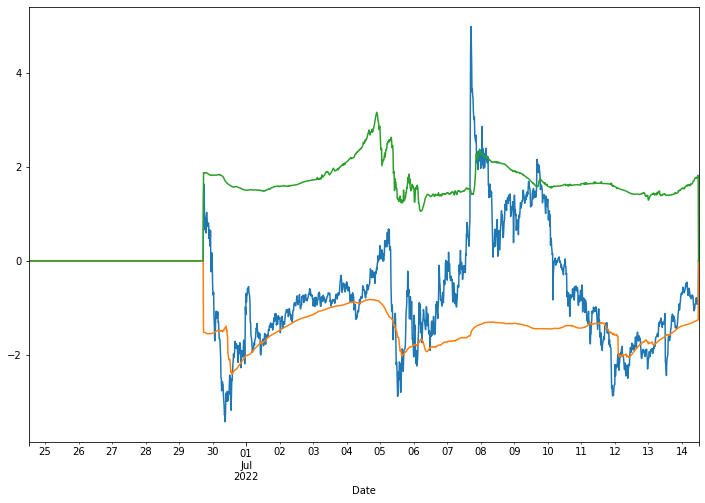

In [86]:
backtester.walkforward_results.zscore.plot(figsize=(12, 8))
backtester.walkforward_results.z_long.plot()
backtester.walkforward_results.z_short.plot()

<AxesSubplot:xlabel='Date'>

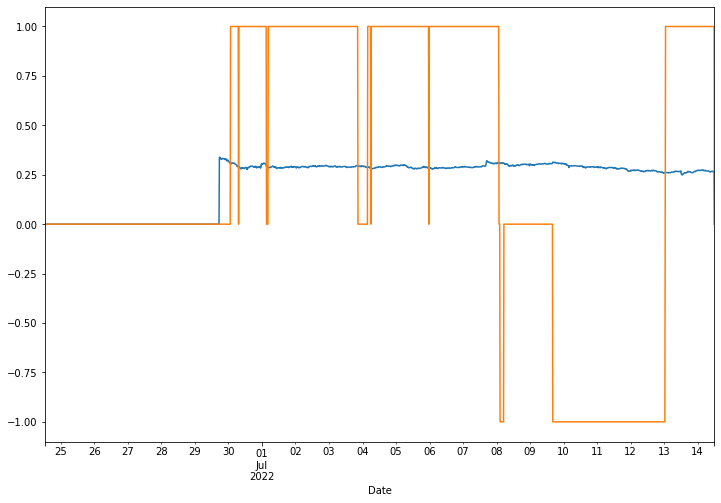

In [87]:
backtester.walkforward_results.spread.plot(figsize=(12, 8))
backtester.walkforward_results.signals.plot()

In [89]:
backtester.walkforward_results

,AUDIOUSDT_FUTURES,AUDIOUSDT_FUTURES_returns_log,FTMUSDT_FUTURES,FTMUSDT_FUTURES_returns_log,signals,AUDIOUSDT_FUTURES_position,FTMUSDT_FUTURES_position,spread,zscore,z_long,z_short,gross_returns,net_returns,gross_cum,net_cum
Date,,,,,,,,,,,,,,,
2022-06-24 12:30:00,0.3856,-0.001555,0.2843,-0.001406,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
2022-06-24 12:45:00,0.3821,-0.009118,0.2819,-0.008478,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
2022-06-24 13:00:00,0.3828,0.001830,0.2816,-0.001065,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
2022-06-24 13:15:00,0.3838,0.002609,0.2854,0.013404,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
2022-06-24 13:30:00,0.3850,0.003122,0.2874,0.006983,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-14 11:00:00,0.3122,-0.005749,0.2368,-0.002109,1,-1,1,0.265384,-0.924835,-1.264375,1.776241,-0.000818,-0.000818,1.217981,1.193386
2022-07-14 11:15:00,0.3114,-0.002566,0.2360,-0.003384,1,-1,1,0.266861,-0.827187,-1.261549,1.790424,-0.004382,-0.004382,1.212656,1.188169
2022-07-14 11:30:00,0.3129,0.004805,0.2361,0.000424,1,-1,1,0.265659,-0.899399,-1.258223,1.810780,0.003842,0.003842,1.217325,1.192743
